In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats
from scipy.interpolate import UnivariateSpline

from wpca.nested_pca import NestedPCA
from wpca.spline import MonotoneQuadraticSplineBasis
from wpca.distribution import PeriodicDistribution
from wpca.barycenter import ProcrustesBarycenter
from wpca.transport import PeriodicTransportMap

In [2]:
df1 = pd.read_excel("data/41598_2021_2025_MOESM2_ESM.xlsx", "Age1")
df1["Group"] = 1
df2 = pd.read_excel("data/41598_2021_2025_MOESM2_ESM.xlsx", "Age2")
df2["Group"] = 2
df3 = pd.read_excel("data/41598_2021_2025_MOESM2_ESM.xlsx", "Age3")
df3["Group"] = 3

df = pd.concat([df1, df2, df3])

df.head()

,Masked_Id_Age1,Cluster_Id_Age1,V1,V2,V3,V4,V5,V6,V7,V8,...,V176,V177,V178,V179,V180,Group,Masked_Id_Age2,Cluster_Id_Age2,Masked_Id_Age3,Cluster_Id_Age3
0,13435OD,7.0,0.003646,0.003648,0.003655,0.003665,0.003679,0.003696,0.003715,0.003737,...,0.003668,0.003662,0.003656,0.003651,0.003647,1,NaN,NaN,NaN,NaN
1,13435OS,7.0,0.003458,0.003357,0.003408,0.003464,0.003518,0.003567,0.003613,0.003657,...,0.003561,0.003529,0.003500,0.003477,0.003462,1,NaN,NaN,NaN,NaN
2,13564OD,7.0,0.002993,0.003013,0.003042,0.003078,0.003116,0.003152,0.003181,0.003205,...,0.002996,0.002989,0.002982,0.002979,0.002982,1,NaN,NaN,NaN,NaN
3,13564OS,2.0,0.002174,0.002197,0.002232,0.002273,0.002320,0.002376,0.002441,0.002515,...,0.002362,0.002317,0.002273,0.002232,0.002198,1,NaN,NaN,NaN,NaN
4,13587OD,1.0,0.002907,0.002940,0.002982,0.003034,0.003097,0.003177,0.003275,0.003396,...,0.002845,0.002844,0.002850,0.002862,0.002881,1,NaN,NaN,NaN,NaN


In [13]:
len(df)

3973

In [14]:
vals = df[df.columns[2:182]].values
age_groups = df["Group"].values
xgrid = np.linspace(0, 1, vals.shape[1])

[]

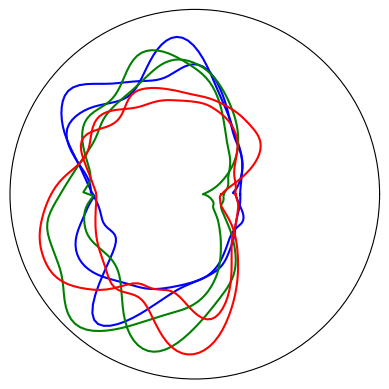

In [4]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
theta = 2 * np.pi * xgrid

colors = ["blue", "green", "red", "orange", "black"]

for i in np.arange(0, 6, 2):
    pdf = vals[i, :]
    pdf = pdf / (np.sum(pdf) * (xgrid[1] - xgrid[0]))
    ax.plot(theta, pdf, color=colors[int(i/2)])
    pdf = vals[i + 1, :]
    pdf = pdf / (np.sum(pdf) * (xgrid[1] - xgrid[0]))
    ax.plot(theta, pdf, color=colors[int(i/2)])
    

ax.set_xticks([])
ax.set_yticks([])

In [126]:
n = vals.shape[0]
n

3973

In [15]:
kept = np.concatenate([
    np.random.choice(df1.shape[0], 150),
    df1.shape[0] + np.random.choice(df2.shape[0], 150),
    df1.shape[0] + df2.shape[0] + np.random.choice(df3.shape[0], 150)])
vals = vals[kept, :]
age_groups = age_groups[kept]

In [16]:
vals.shape

(450, 180)

In [17]:
heights = np.array([np.sum(age_groups == i) for i in range(1, 4)])
print(heights)

[150 150 150]


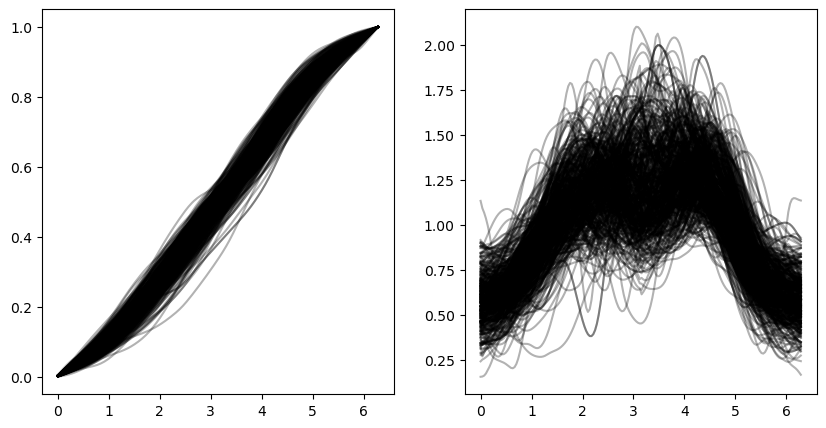

In [18]:
measures = []

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


for i in range(vals.shape[0]):
    pdf = vals[i, :]
    pdf = pdf / (np.sum(pdf) * (xgrid[1]- xgrid[0]))
    cdf = np.cumsum(pdf) * (xgrid[1]- xgrid[0])
    dist = PeriodicDistribution(supp_grid=xgrid, cdf_eval=cdf)
    measures.append(dist)
    axes[0].plot(xgrid * 2 * np.pi, cdf, color="black", alpha=0.3)
    axes[1].plot(xgrid * 2 * np.pi, pdf, color="black", alpha=0.3)
    
# plt.savefig("/Users/marioberaha/Dropbox/Wass_S1/JASA/IMG/eyes_data.pdf", bbox_inches="tight")

In [19]:
bary = ProcrustesBarycenter(maxiter=5, threshold=1e-3)
bary.compute(measures)
bary_measure = bary.bary_measure

0.0014352681142453666
1.724071558969731e-05


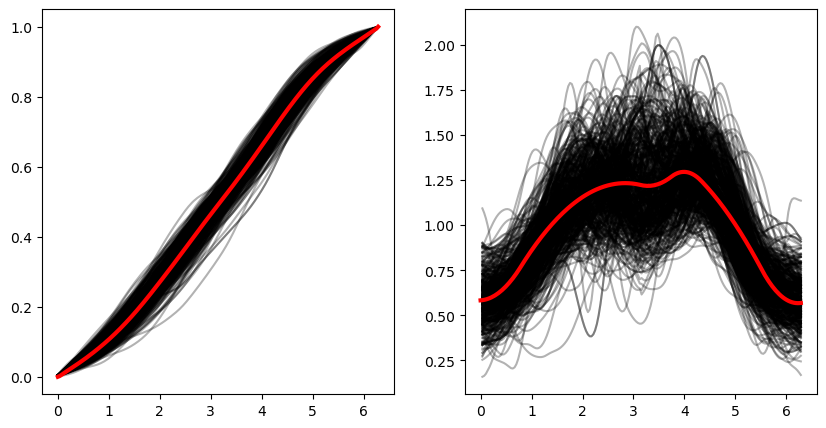

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))


for m in measures:
    cdf = m.cdf(xgrid)
    pdf = np.diff(cdf) / (xgrid[1] - xgrid[0])
    axes[0].plot(xgrid * 2 * np.pi, cdf, color="black", alpha=0.3)
    axes[1].plot(xgrid[1:] * 2 * np.pi, pdf, color="black", alpha=0.3)


axes[0].plot(xgrid * 2 * np.pi, bary_measure.cdf(xgrid), color="red", lw=3)
axes[1].plot(xgrid* 2 * np.pi, bary_measure.eval_smooth_pdf(xgrid), color="red", lw=3)

plt.savefig("eyes_data_bary_new.pdf", bbox_inches="tight")

# Compare Wasserstein vs Log-Distances

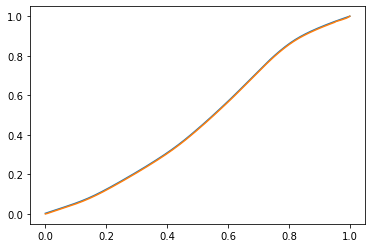

In [9]:
from scipy.integrate import trapz

transports_from_bary = []
for m in measures:
    t = PeriodicTransportMap(bary_measure)
    t.compute(m)
    transports_from_bary.append(t)

In [ ]:
# compare distances

n = len(measures)
quant_grid = np.linspace(0, 1, 1000)

bary_pdf = bary_measure.eval_smooth_pdf(quant_grid)

w_dists = np.zeros((n, n))
log_dists = np.zeros((n, n))

for i in range(n):
    print("i: {0} / {1}".format(i+1, n))
    for j in range(n):
        tmap = PeriodicTransportMap(measures[i])
        tmap.compute(measures[j])
        w_dists[i, j] = tmap.wdist(tmap.theta, quant_grid)
        
        log_dists[i, j] = trapz(
            (transports_from_bary[i](quant_grid) - transports_from_bary[j](quant_grid))**2 
            * bary_pdf,
            quant_grid)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(20):
    ax.scatter(w_dists[i, :], log_dists[i, :], color="black", alpha=0.5)
    
maxd = np.max([np.max(w_dists), np.max(log_dists)])
    
plt.plot(np.linspace(0, maxd, 10), np.linspace(0, maxd, 10), color="red", lw=2)
ax.set_aspect('equal')

# plt.savefig("/Users/marioberaha/Dropbox/Wass_S1/JASA/IMG/eyes_dists.pdf", bbox_inches="tight")

# Fit PCA

In [22]:
npca = NestedPCA(nbasis=50)
npca.fit(measures, bary_measure, 2)

In [23]:
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.ndimage.filters import uniform_filter1d
from wpca.spline import MonotoneQuadraticSplineBasis



def get_smooth_cdf(measure, xgrid):
    ext_grid = np.linspace(-1, 2, 5000)
    cdf_eval = measure.periodic_cdf(0, ext_grid)
    cdf_eval = uniform_filter1d(cdf_eval, size=250)
    cdf_spline = UnivariateSpline(ext_grid, cdf_eval, s=0.01)
    return cdf_spline(xgrid)



def get_smooth_pdf(measure, xgrid):
    ext_grid = np.linspace(-1, 2, 5000)
    cdf_eval = measure.periodic_cdf(0, ext_grid)
    cdf_eval = uniform_filter1d(cdf_eval, size=250)
    cdf_spline = UnivariateSpline(ext_grid, cdf_eval, s=0.01)
    return cdf_spline.derivative()(xgrid)

/var/folders/c3/_f3tgzn14ylfqqgqhkdntngh0000gn/T/ipykernel_71655/1959043109.py:2: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


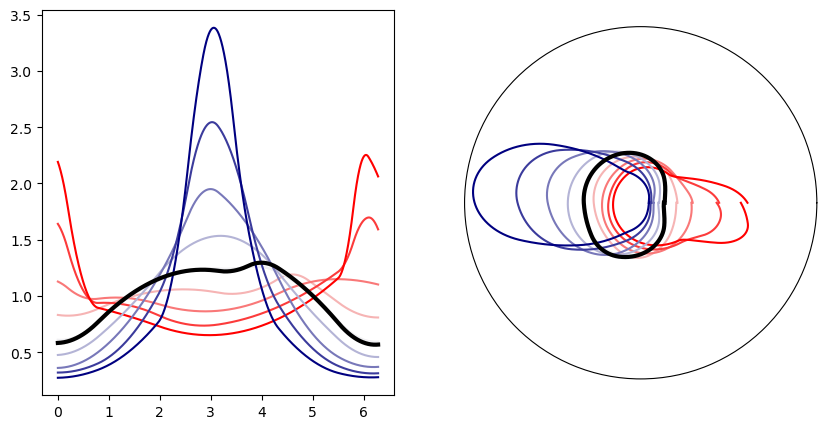

In [39]:
import seaborn as sns

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="polar")

ind = 0

ext_grid = np.linspace(0, 1, 5000)
theta_grid = 2 * np.pi * ext_grid

pos_lambdas = np.linspace(0.000001, 0.1, 5)
neg_lambdas = np.linspace(-0.00001, -0.1, 5)
pos_palette = sns.light_palette("red", n_colors=len(pos_lambdas))
neg_palette = sns.light_palette("navy", n_colors=len(neg_lambdas))

for i, lam in enumerate(pos_lambdas):
    proj = npca.center + npca.project(lam * npca.eig_vecs[:, ind])
    transport = PeriodicTransportMap(bary_measure)
    t_eval = npca.spline_basis.eval_spline(proj)
    m = transport.get_pushforward_from_transport(npca.spline_basis.xgrid, t_eval)

    pdf = get_smooth_pdf(m, ext_grid)
    ax1.plot(theta_grid, pdf, color=pos_palette[i])
    ax2.plot(theta_grid, pdf, color=pos_palette[i])

for i, lam in enumerate(neg_lambdas):
    proj = npca.center + npca.project(lam * npca.eig_vecs[:, ind])
    transport = PeriodicTransportMap(bary_measure)
    t_eval = npca.spline_basis.eval_spline(proj)
    m = transport.get_pushforward_from_transport(npca.spline_basis.xgrid, t_eval)
    pdf = get_smooth_pdf(m, ext_grid)
    ax1.plot(theta_grid, pdf, color=neg_palette[i])
    ax2.plot(theta_grid, pdf, color=neg_palette[i])
    

ax1.plot(theta_grid, bary_measure.eval_smooth_pdf(ext_grid), color="black", lw=3)
ax2.plot(theta_grid, bary_measure.eval_smooth_pdf(ext_grid), color="black", lw=3)

ax2.set_xticks([])
ax2.set_yticks([])
    
#plt.plot(ext_grid, bary_measure.periodic_cdf(0, ext_grid), color="red", lw=2)
plt.savefig("eyes_1pd_new.pdf", bbox_inches="tight")
plt.show()

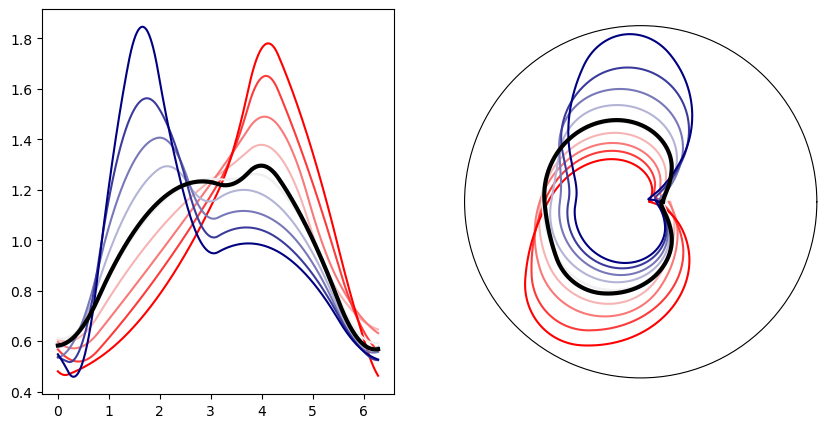

In [40]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="polar")

ind = 1

pos_lambdas = np.linspace(0.000001, 0.05, 5)
neg_lambdas = np.linspace(-0.00001, -0.05, 5)
pos_palette = sns.light_palette("red", n_colors=len(pos_lambdas))
neg_palette = sns.light_palette("navy", n_colors=len(neg_lambdas))

for i, lam in enumerate(pos_lambdas):
    proj = npca.center + npca.project(lam * npca.eig_vecs[:, ind])
    transport = PeriodicTransportMap(bary_measure)
    t_eval = npca.spline_basis.eval_spline(proj)
    m = transport.get_pushforward_from_transport(npca.spline_basis.xgrid, t_eval)

    pdf = get_smooth_pdf(m, ext_grid)
    ax1.plot(theta_grid, pdf, color=pos_palette[i])
    ax2.plot(theta_grid, pdf, color=pos_palette[i])

for i, lam in enumerate(neg_lambdas):
    proj = npca.center + npca.project(lam * npca.eig_vecs[:, ind])
    transport = PeriodicTransportMap(bary_measure)
    t_eval = npca.spline_basis.eval_spline(proj)
    m = transport.get_pushforward_from_transport(npca.spline_basis.xgrid, t_eval)
    pdf = get_smooth_pdf(m, ext_grid)
    ax1.plot(theta_grid, pdf, color=neg_palette[i])
    ax2.plot(theta_grid, pdf, color=neg_palette[i])

    
ax1.plot(theta_grid, bary_measure.eval_smooth_pdf(ext_grid), color="black", lw=3)
ax2.plot(theta_grid, bary_measure.eval_smooth_pdf(ext_grid), color="black", lw=3)

ax2.set_xticks([])
ax2.set_yticks([])
plt.savefig("eyes_2pd_new.pdf", bbox_inches="tight")

plt.show()

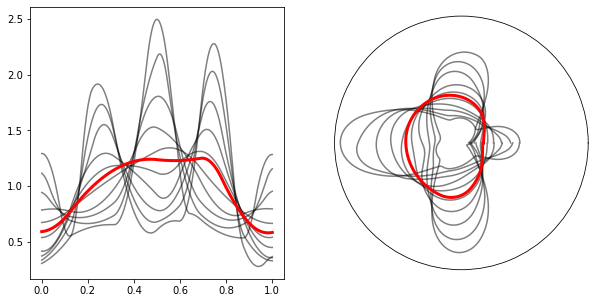

In [28]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection="polar")

ind = 2

for lam in np.linspace(-0.05, 0.05, 10):
    proj = npca.center + npca.project(lam * npca.eig_vecs[:, ind])
    transport = PeriodicTransportMap(bary_measure)
    t_eval = npca.spline_basis.eval_spline(proj)
    m = transport.get_pushforward_from_transport(npca.spline_basis.xgrid, t_eval)
    pdf = get_smooth_pdf(m, ext_grid)
    ax1.plot(ext_grid, pdf, color="black", alpha=0.5)
    ax2.plot(theta_grid, pdf, color="black", alpha=0.5)
    
ax1.plot(ext_grid, bary_measure.eval_smooth_pdf(ext_grid), color="red", lw=3)
ax2.plot(theta_grid, bary_measure.eval_smooth_pdf(ext_grid), color="red", lw=3)

ax2.set_xticks([])
ax2.set_yticks([])

# plt.savefig("/Users/marioberaha/Dropbox/Wass_S1/JASA/IMG/eyes_3pd.pdf", bbox_inches="tight")

plt.show()

# Measure the Reconstruction Error

In [225]:
scores = npca.transform(measures)

In [227]:
## Reconstruction

err_by_dim = []

for dim in range(1, 26):
    curr_scores = scores.copy()
    curr_scores[:, dim:] = 0

    rec_coeffs = npca.pt_from_proj(curr_scores) + npca.center
    
    errs = []
    dists_from_bary = []
    for i in range(len(measures)):
        print("\r{0} / {1}".format(i+1, len(measures)), flush=True, end=" ")
        tmap = PeriodicTransportMap(bary_measure)
        tmap.compute(measures[i])
        dists_from_bary.append(tmap.wdist(tmap.theta, quant_grid))

        t_eval = npca.spline_basis.eval_spline(rec_coeffs[i, :])
        rec_measure = tmap.get_pushforward_from_transport(
            npca.spline_basis.xgrid, t_eval)
        tmap2 = PeriodicTransportMap(measures[i])
        tmap2.compute(rec_measure)
        errs.append(tmap2.wdist(tmap2.theta, quant_grid))
        
    err_by_dim.append(np.mean(np.array(errs) / np.array(dists_from_bary)))

450 / 450    

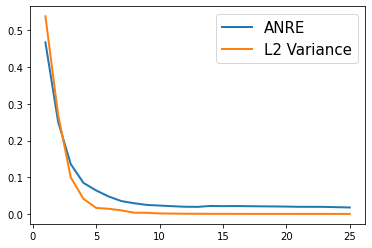

In [263]:
plt.plot(np.arange(1, 26), err_by_dim, lw=2, label="ANRE")
plt.plot(np.arange(1, 26), (npca.eig_val / np.sum(npca.eig_val))[:25], lw=2, label="L2 Variance")
plt.legend(fontsize=15)
plt.savefig("/Users/marioberaha/Dropbox/Wass_S1/JASA/IMG/eye_l2_vs_nre.pdf", bbox_inches="tight")

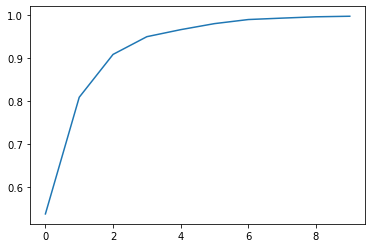

In [207]:
plt.plot((np.cumsum(npca.eig_val) / np.sum(npca.eig_val))[:10] )

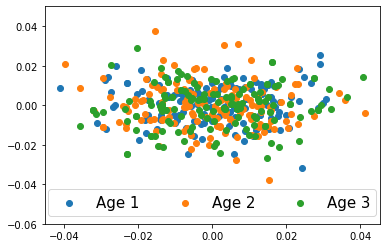

In [262]:
for a in np.unique(age_groups):
    tmp = scores[age_groups == a, :]
    plt.scatter(tmp[:, 0], tmp[:,1], label = "Age {0}".format(a))
    
plt.ylim(-0.06, 0.05)
    
plt.legend(ncol=3, loc="lower center", fontsize=15)
plt.savefig("/Users/marioberaha/Dropbox/Wass_S1/JASA/IMG/scoreplot_eye.pdf", bbox_inches="tight")

# Clustering on the Scores

In [134]:
from scipy.cluster.hierarchy import dendrogram, cut_tree
from sklearn.cluster import AgglomerativeClustering

In [135]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, **kwargs), linkage_matrix

In [136]:
features = npca.transform(measures)
features.shape

(450, 5)

In [166]:
clus = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="complete")
clus = clus.fit(features)

In [ ]:
fig.

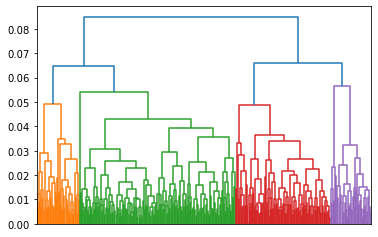

In [284]:
fig = plt.figure()

den, link = plot_dendrogram(clus, truncate_mode="level")
plt.xticks([])
plt.savefig("/Users/marioberaha/Dropbox/Wass_S1/JASA/IMG/eye_dendrogram.pdf", bbox_inches="tight")
plt.show()

In [291]:
clusters = cut_tree(link, n_clusters=8)[:, 0]
_, cards = np.unique(clusters, return_counts=True)

In [292]:
np.argsort(cards)

array([7, 5, 6, 0, 3, 4, 1, 2])

In [293]:
measures = np.array(measures)
bary_in_clus = []

for c in range(np.max(clusters) + 1):
    bary_clus = ProcrustesBarycenter(maxiter=5, threshold=1e-3)
    bary_clus.compute(measures[np.where(clusters == c)[0]])
    bary_in_clus.append(bary_clus)

0.0001706662006432174
0.002401363644466346
1.3743167079939355e-05
0.0011087794381746219
1.4525645006032333e-05
0.000685945068499075
0.0035460295970608726
1.8851914848253498e-05
0.004823804923609624
3.46450871815261e-06
0.003029161342689136
7.038935569886437e-06
0.001391175254642441
1.073842572722505e-05


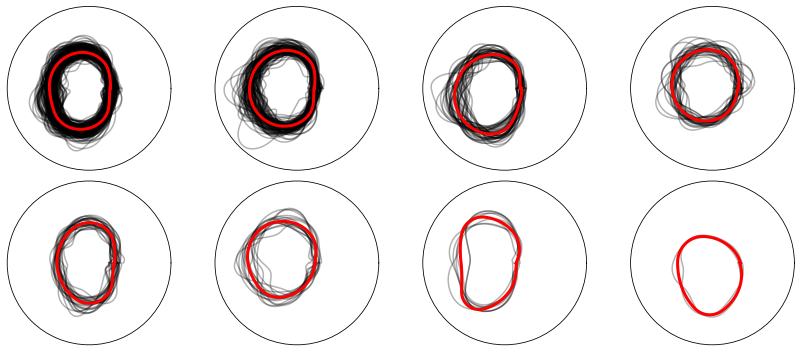

In [304]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(241, projection="polar")
ax2 = fig.add_subplot(242, projection="polar")
ax3 = fig.add_subplot(243, projection="polar")
ax4 = fig.add_subplot(244, projection="polar")
ax5 = fig.add_subplot(245, projection="polar")
ax6 = fig.add_subplot(246, projection="polar")
ax7 = fig.add_subplot(247, projection="polar")
ax8 = fig.add_subplot(248, projection="polar")

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

theta_grid = np.linspace(0, 2 * np.pi, 180)

x_grid_bary = np.linspace(0, 1, 500)
theta_grid_bary = 2 * np.pi * x_grid_bary


for i, c in enumerate(np.argsort(cards)[::-1]):
    #curr = vals[np.where(clusters == c)[0], :]
    curr = measures[np.where(clusters == c)[0]]
    for dens in curr:
        axes[i].plot(theta_grid_bary, dens.eval_smooth_pdf(x_grid_bary), 
                     alpha= 0.3, color="black")
        
    bary_measure = bary_in_clus[c].bary_measure
    axes[i].plot(theta_grid_bary, 
                 bary_measure.eval_smooth_pdf(x_grid_bary), 
                 color="red", lw=3)
        
    axes[i].set_ylim([0, 2.4])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    

plt.tight_layout()
#ax2.plot(theta_grid, bary_measure.eval_smooth_pdf(ext_grid), color="red", lw=3)

#ax2.set_xticks([])
#ax2.set_yticks([])
# plt.savefig("/Users/marioberaha/Dropbox/Wass_S1/JASA/IMG/eyes_clusters.pdf", bbox_inches="tight")

plt.show()

[71 72 65]
[38 37 36]
[11 15 21]
[13  8 10]
[ 9  7 11]
[2 8 6]
[5 2 1]
[1 1 0]


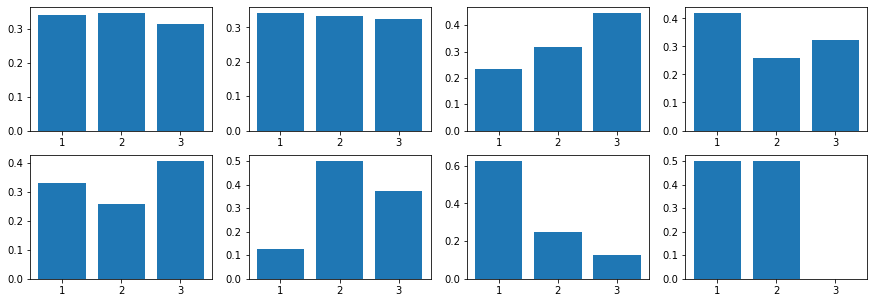

In [289]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))

axes = axes.flat

for i, c in enumerate(np.argsort(cards)[::-1]):
    curr = age_groups[np.where(clusters == c)[0]]
    heights = np.array([np.sum(curr == i) for i in range(1, 4)])
    print(heights)
    axes[i].bar(np.arange(1, 4), heights / heights.sum())

In [285]:
## cut to get 2 clusters

clusters = cut_tree(link, n_clusters=2)[:, 0]
_, cards = np.unique(clusters, return_counts=True)

measures = np.array(measures)
bary_in_clus = []

for c in range(np.max(clusters) + 1):
    bary_clus = ProcrustesBarycenter(maxiter=5, threshold=1e-3)
    bary_clus.compute(measures[np.where(clusters == c)[0]])
    bary_in_clus.append(bary_clus)

0.0008616191310110977
0.0027354237369726937
1.7334033864813847e-05


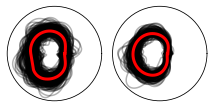

In [286]:
fig = plt.figure()

ax1 = fig.add_subplot(241, projection="polar")
ax2 = fig.add_subplot(242, projection="polar")

axes = [ax1, ax2]

theta_grid = np.linspace(0, 2 * np.pi, 180)

x_grid_bary = np.linspace(0, 1, 500)
theta_grid_bary = 2 * np.pi * x_grid_bary


for i, c in enumerate(np.argsort(cards)[::-1]):
    #curr = vals[np.where(clusters == c)[0], :]
    curr = measures[np.where(clusters == c)[0]]
    for dens in curr:
        axes[i].plot(theta_grid_bary, dens.eval_smooth_pdf(x_grid_bary), 
                     alpha= 0.3, color="black")
        
    bary_measure = bary_in_clus[c].bary_measure
    axes[i].plot(theta_grid_bary, 
                 bary_measure.eval_smooth_pdf(x_grid_bary), 
                 color="red", lw=3)
        
    # axes[c].set_ylim([0, 0.015])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    

plt.tight_layout()
#ax2.plot(theta_grid, bary_measure.eval_smooth_pdf(ext_grid), color="red", lw=3)

#ax2.set_xticks([])
#ax2.set_yticks([])
plt.savefig("/Users/marioberaha/Dropbox/Wass_S1/JASA/IMG/eyes_2clusters.pdf", bbox_inches="tight")

plt.show()